In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')

In [3]:
'''# LOAD LIBRARIES
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd, numpy as np, gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import statsmodels.api as sm

# GET INDICIES OF REAL TEST DATA FOR FE
#######################
# TAKE FROM YAG320'S KERNEL
# https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

test_path = '../input/test.csv'

df_test = pd.read_csv(test_path)
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')

###################

d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

train = pd.read_csv('../input/train.csv', dtype=d)
test = pd.read_csv('../input/test.csv', dtype=d)

print('Loaded',len(train),'rows of train')
print('Loaded',len(test),'rows of test')'''

'# LOAD LIBRARIES\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd, numpy as np, gc\nimport warnings\nwarnings.filterwarnings("ignore")\nfrom sklearn.metrics import roc_auc_score\nimport lightgbm as lgb\nimport statsmodels.api as sm\n\n# GET INDICIES OF REAL TEST DATA FOR FE\n#######################\n# TAKE FROM YAG320\'S KERNEL\n# https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split\n\ntest_path = \'../input/test.csv\'\n\ndf_test = pd.read_csv(test_path)\ndf_test.drop([\'ID_code\'], axis=1, inplace=True)\ndf_test = df_test.values\n\nunique_samples = []\nunique_count = np.zeros_like(df_test)\nfor feature in range(df_test.shape[1]):\n    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)\n    unique_count[index_[count_ == 1], feature] += 1\n\n# Samples which have unique values are real the others are fake\nreal_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]\nsynthetic_samp

In [4]:
'''# FREQUENCY ENCODE
def encode_FE(df,col,test):
    cv = df[col].value_counts()
    nm = col+'_FE'
    df[nm] = df[col].map(cv)
    test[nm] = test[col].map(cv)
    test[nm].fillna(0,inplace=True)
    if cv.max()<=255:
        df[nm] = df[nm].astype('uint8')
        test[nm] = test[nm].astype('uint8')
    else:
        df[nm] = df[nm].astype('uint16')
        test[nm] = test[nm].astype('uint16')        
    return

test['target'] = -1
comb = pd.concat([train,test.loc[real_samples_indexes]],axis=0,sort=True)
for i in range(200): encode_FE(comb,'var_'+str(i),test)
train = comb[:len(train)]; del comb
print('Added 200 new magic features!')'''

"# FREQUENCY ENCODE\ndef encode_FE(df,col,test):\n    cv = df[col].value_counts()\n    nm = col+'_FE'\n    df[nm] = df[col].map(cv)\n    test[nm] = test[col].map(cv)\n    test[nm].fillna(0,inplace=True)\n    if cv.max()<=255:\n        df[nm] = df[nm].astype('uint8')\n        test[nm] = test[nm].astype('uint8')\n    else:\n        df[nm] = df[nm].astype('uint16')\n        test[nm] = test[nm].astype('uint16')        \n    return\n\ntest['target'] = -1\ncomb = pd.concat([train,test.loc[real_samples_indexes]],axis=0,sort=True)\nfor i in range(200): encode_FE(comb,'var_'+str(i),test)\ntrain = comb[:len(train)]; del comb\nprint('Added 200 new magic features!')"

In [5]:
#train

## **train and test dataset**

In [6]:
import seaborn as sns
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
corrs = train.corr()

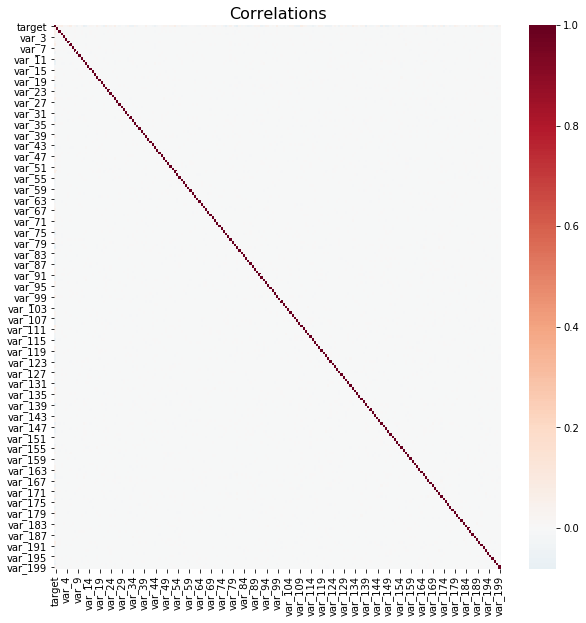

In [8]:
#heat map
plt.figure(figsize=(10,10))
sns.heatmap(corrs, cmap='RdBu_r', center=0.0) 
plt.title('Correlations',fontsize=16)
plt.show() 

In [9]:
x_train = train.iloc[:,2:]
y_train = train['target']
x_test = test.iloc[:,1:]


In [10]:
print('train_feature shape:', x_train.shape)
print('train_target shape:', y_train.shape)
print('test_feature shape:', x_test.shape)

train_feature shape: (200000, 200)
train_target shape: (200000,)
test_feature shape: (200000, 200)


In [11]:
# augment sample to deal with the imbalanced dataset
def disarrange(a, axis=-1):
    """
    Shuffle `a` in-place along the given axis.

    Apply numpy.random.shuffle to the given axis of `a`.
    Each one-dimensional slice is shuffled independently.
    """
    b = a.swapaxes(axis, -1)
    # Shuffle `b` in-place along the last axis.  `b` is a view of `a`,
    # so `a` is shuffled in place, too.
    shp = b.shape[:-1]
    for ndx in np.ndindex(shp):
        np.random.shuffle(b[ndx])
    return

def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        disarrange(x1,axis=0)
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        disarrange(x1,axis=0)
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [12]:
#augment step
x_train_a, y_train_a = augment(x_train.values, y_train.values)

In [13]:
#switch augmented data from array to dataframe
#x_train_a_frame = pd.DataFrame(x_train_a)
#y_train_a_frame = pd.DataFrame(y_train_a)

In [14]:
#print("the train_set_feature shape:", x_train_a.shape)
#print("the train_set_labels shape:", y_train_a.shape)

## **NN **

In [15]:
# random separate the train and vaild.
#agumented data make the overfitting



rand_ind = np.random.permutation(200000)
train_ind = rand_ind[0:180000]
valid_ind = rand_ind[180000:200000]

x_valid_vec = x_train.iloc[valid_ind,:]
y_valid_vec = y_train.iloc[valid_ind]

x_train_vec = x_train.iloc[train_ind,:]
y_train_vec = y_train.iloc[train_ind]



In [16]:
from keras import models
from keras import layers
from keras import optimizers

Using TensorFlow backend.


In [17]:
'''from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2)
train_poly = poly.fit(
    poly.fit_transform(x_train_vec),
    y_train_vec,
    batch_size = 32
)'''

'''for i in range(1000):
    index = .......
    xi = data[index]
    fi = feature_map() #function
    model.train_on_batch([fi,yi])'''

'for i in range(1000):\n    index = .......\n    xi = data[index]\n    fi = feature_map() #function\n    model.train_on_batch([fi,yi])'

In [18]:
#build NN model
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape = (200,)))
model.add(layers.Dense(20))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(48, activation='relu'))
model.add(layers.Dense(128))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                2010      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                1008      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               6272      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
__________

In [20]:
model.compile(optimizers.RMSprop(lr=2E-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [21]:
history = model.fit(x_train_vec,y_train_vec,
                  batch_size=32,epochs=50,
                  validation_data=(x_valid_vec,y_valid_vec))

Instructions for updating:
Use tf.cast instead.
Train on 180000 samples, validate on 20000 samples
Epoch 1/50
180000/180000 [==============================] - 46s 257us/step - loss: 0.3023 - acc: 0.9005 - val_loss: 0.2600 - val_acc: 0.9082
Epoch 2/50
180000/180000 [==============================] - 44s 243us/step - loss: 0.2570 - acc: 0.9078 - val_loss: 0.2477 - val_acc: 0.9117
Epoch 3/50
180000/180000 [==============================] - 43s 238us/step - loss: 0.2500 - acc: 0.9094 - val_loss: 0.2392 - val_acc: 0.9143
Epoch 4/50
180000/180000 [==============================] - 43s 240us/step - loss: 0.2470 - acc: 0.9105 - val_loss: 0.2393 - val_acc: 0.9141
Epoch 5/50
180000/180000 [==============================] - 43s 240us/step - loss: 0.2461 - acc: 0.9100 - val_loss: 0.2356 - val_acc: 0.9144
Epoch 6/50
180000/180000 [==============================] - 43s 237us/step - loss: 0.2454 - acc: 0.9111 - val_loss: 0.2347 - val_acc: 0.9142
Epoch 7/50
180000/180000 [=============================

In [22]:
nn_result = model.predict(x_test)

In [23]:
nn_result = nn_result.reshape(1,200000)

In [24]:
from sklearn.metrics import roc_auc_score
nn_train_result = model.predict(x_train)
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(y_train, nn_train_result)))


 >> CV score: 0.85893 


## **XBG**


In [25]:
from xgboost import XGBClassifier
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold


In [26]:
skf = StratifiedKFold(n_splits =4,random_state = 0,shuffle=False)
for train_index, test_index in skf.split(x_train_a,y_train_a):
    x_train_skf,x_val_skf = x_train_a[train_index],x_train_a[test_index]
    y_train_skf,y_val_skf = y_train_a[train_index],y_train_a[test_index]
    

In [27]:
clf = XGBClassifier(colsample_bylevel = 0.8015579071911014,
        colsample_bytree = 0.44364889457651413,
        gamma = 3.811128976537413e-05,
        learning_rate = 0.2700390206185342,
        max_delta_step = 18,
        max_depth = 36,
        min_child_weight = 2,
        n_estimators = 83,
        reg_alpha = 1.5057560255472018e-06,
        reg_lambda = 0.08186810622382998,
        scale_pos_weight = 0.02900459363415458,
        subsample = 0.8835665823899177)
clf.fit(x_train_skf,y_train_skf,eval_set = [(x_train_skf,y_train_skf),(x_val_skf,y_val_skf)],
       eval_metric='auc',early_stopping_rounds=10)
evals_results = clf.evals_result()

[0]	validation_0-auc:0.611406	validation_1-auc:0.607654
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.682545	validation_1-auc:0.676406
[2]	validation_0-auc:0.72716	validation_1-auc:0.721336
[3]	validation_0-auc:0.749117	validation_1-auc:0.740756
[4]	validation_0-auc:0.773073	validation_1-auc:0.75725
[5]	validation_0-auc:0.780537	validation_1-auc:0.759002
[6]	validation_0-auc:0.792754	validation_1-auc:0.763056
[7]	validation_0-auc:0.808476	validation_1-auc:0.766319
[8]	validation_0-auc:0.82869	validation_1-auc:0.774436
[9]	validation_0-auc:0.8414	validation_1-auc:0.779084
[10]	validation_0-auc:0.853502	validation_1-auc:0.78305
[11]	validation_0-auc:0.865421	validation_1-auc:0.788624
[12]	validation_0-auc:0.872777	validation_1-auc:0.79355
[13]	validation_0-auc:0.881118	validation_1-auc:0.800998
[14]	validation_0-auc:0.885355	validation_1-auc:0.804065
[15]	

In [28]:
x_test_a = np.array(x_test)
x_test_a

array([[ 11.0656,   7.7798,  12.9536, ...,  10.72  ,  15.4722,  -8.7197],
       [  8.5304,   1.2543,  11.3047, ...,   9.8714,  19.1293, -20.976 ],
       [  5.4827, -10.3581,  10.1407, ...,   7.0618,  19.8956, -23.1794],
       ...,
       [ 11.636 ,   2.2769,  11.2074, ...,   9.1933,  11.7905, -22.2762],
       [ 13.5745,  -0.5134,  13.6584, ...,   8.1079,   8.7735,  -0.2122],
       [ 10.4664,   1.807 ,  10.2277, ...,  10.3378,  14.334 ,  -7.7094]])

In [29]:
xgb_result = clf.predict(x_test_a)

In [30]:
xgb_result = xgb_result.reshape(1,200000)

In [31]:
xgb_result

array([[0., 0., 0., ..., 0., 0., 0.]])

In [32]:
from sklearn.metrics import roc_auc_score
xgb_train_result = clf.predict(x_train_a)
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(y_train_a, xgb_train_result)))


 >> CV score: 0.59756 


## **LGB**

In [33]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [34]:
from sklearn.model_selection import KFold
num_folds = 11
features = [c for c in x_train.columns if c not in ['ID_code', 'target']]
#target = x_train['target']

folds = KFold(n_splits=num_folds, random_state=2319)
#oof = np.zeros(len(x_train))
#getVal = np.zeros(len(x_train))
lgb_result = np.zeros(len(y_train))
#feature_importance_df = pd.DataFrame()

In [35]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    
    X_train_lgb, y_train_lgb = x_train.iloc[trn_idx], y_train.iloc[trn_idx]
    X_valid_lgb, y_valid_lgb = x_train.iloc[val_idx], y_train.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train_lgb.values, y_train_lgb.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid_lgb, label=y_valid_lgb)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    #oof[val_idx] = clf.predict(x_train.iloc[val_idx], num_iteration=clf.best_iteration)
    #getVal[val_idx]+= clf.predict(x_train.iloc[val_idx], num_iteration=clf.best_iteration) / folds.n_splits
    
    #fold_importance_df = pd.DataFrame()
    #fold_importance_df["feature"] = features
    #fold_importance_df["importance"] = clf.feature_importance()
    #fold_importance_df["fold"] = fold_ + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    lgb_result += clf.predict(x_test, num_iteration=clf.best_iteration) / folds.n_splits

Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912047	valid_1's auc: 0.896537
[10000]	training's auc: 0.921936	valid_1's auc: 0.90067
[15000]	training's auc: 0.929487	valid_1's auc: 0.901356
[20000]	training's auc: 0.936352	valid_1's auc: 0.901039
Early stopping, best iteration is:
[16445]	training's auc: 0.931512	valid_1's auc: 0.901398
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912864	valid_1's auc: 0.895124
[10000]	training's auc: 0.922619	valid_1's auc: 0.89839
[15000]	training's auc: 0.930132	valid_1's auc: 0.898496
Early stopping, best iteration is:
[11853]	training's auc: 0.925561	valid_1's auc: 0.898695
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912482	valid_1's auc: 0.88983
[10000]	training's auc: 0.922325	valid_1's auc: 0.893084
[15000]	training's auc: 0.929923	valid_1's auc: 0.893396
Early stopping, best iterat

In [36]:
from sklearn.metrics import roc_auc_score
lgb_train_result = clf.predict(x_train)
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(y_train, lgb_train_result)))


 >> CV score: 0.93071 


In [37]:
lgb_result = lgb_result.reshape(1,200000)

In [38]:
lg_r = np.array(lgb_result)

**result**

In [39]:
n = 0.4*nn_result + 0.2*xgb_result + 0.4*lg_r

In [40]:
final_result = n.reshape(200000,1)

In [41]:

sample_submission['target'] = final_result
sample_submission.to_csv('submission.csv',index = False)